<a href="https://colab.research.google.com/github/TJTomas/DSPS_TTomaszewski/blob/main/HW6/Tomaszewski_Second_Half_fitlinetogrbafterglow_mcmc_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [359]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
# you will need more imports, put them here


# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [360]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


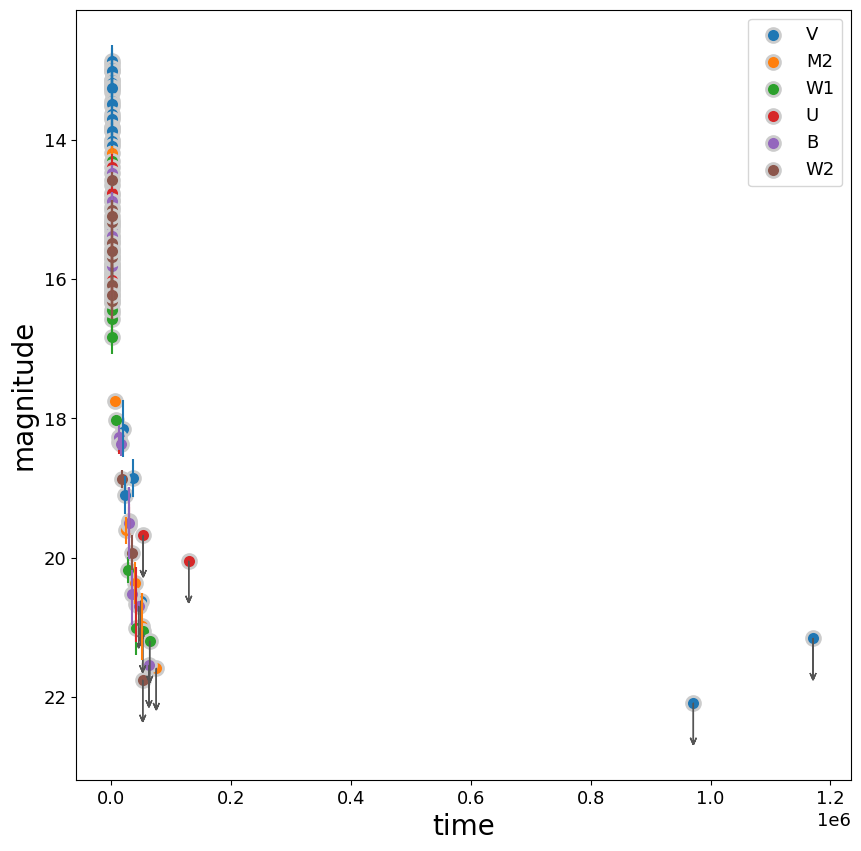

In [361]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [362]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [363]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

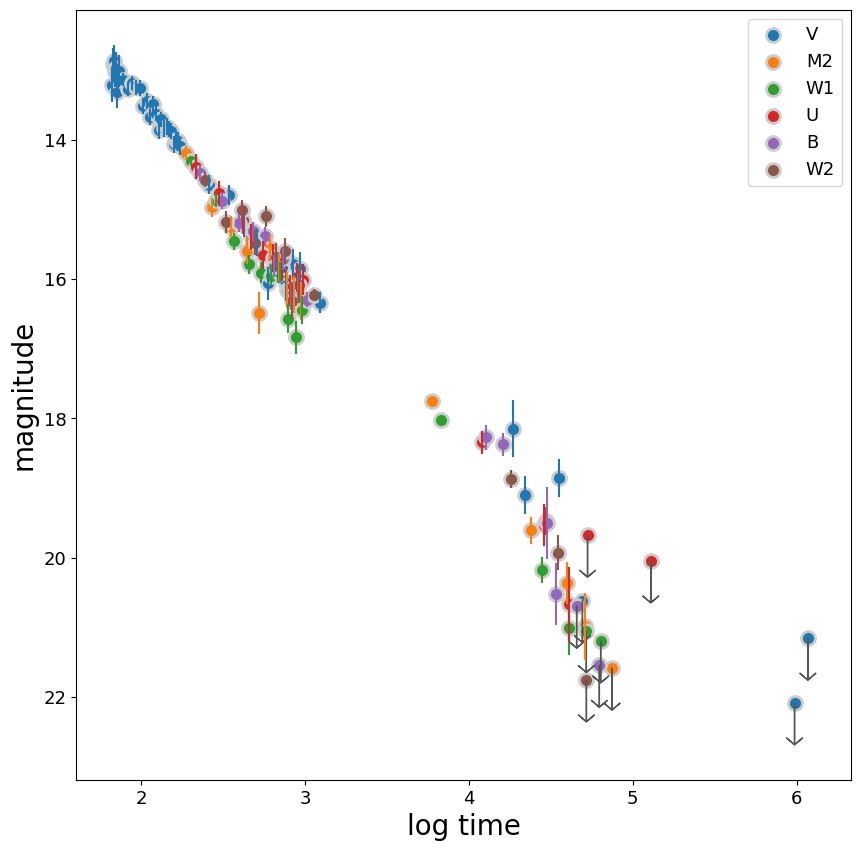

In [364]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [365]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [366]:
x = grbAGnouplim.logtime.values
#pick a function to expand the axis
#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [367]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [368]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [369]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return intercept + slope * x

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332889501873
        x: [ 8.225e+00  2.641e+00]
      nit: 14
      jac: [-1.254e-01 -2.083e+00]
 hess_inv: [[ 2.054e-02 -4.529e-03]
            [-4.529e-03  1.001e-03]]
     nfev: 300
     njev: 96

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [370]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725498
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [-1.192e-07 -3.576e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [371]:
l2?

In [372]:
l1?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [373]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess = 8, 2

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


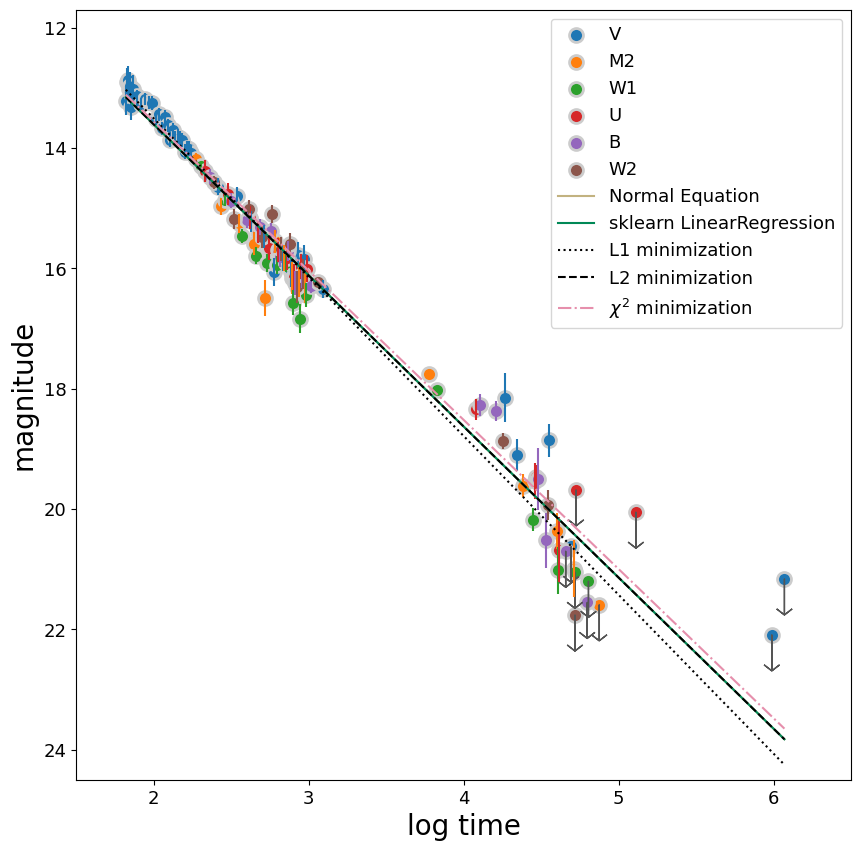

In [374]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


# RERWITE THIS CAPTION!

# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [375]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [376]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.97
score on the training set 0.99


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [377]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [378]:
import emcee #import the package - please move this to the top with the other imports!

In [379]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ~ P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [380]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [381]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)



In [382]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [383]:
#initial guess
ig = [1,10]

In [384]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [385]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [386]:
pos.shape

(32, 2)

In [387]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [388]:
# this runs the MCMC for 1,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:01<00:00, 716.68it/s]


In [389]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [390]:
samples.shape

(1000, 32, 2)

In [391]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 1000)

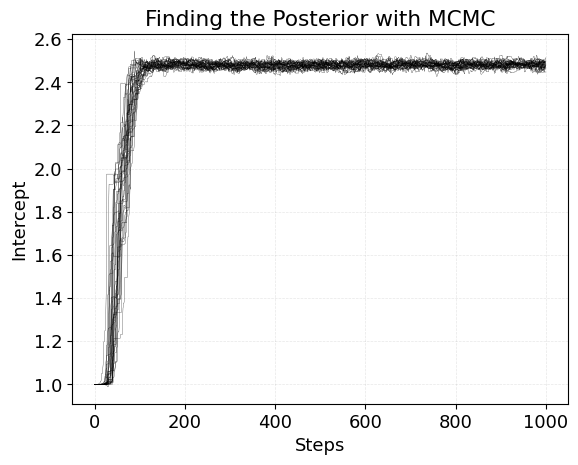

In [392]:

for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1)

pl.title("Finding the Posterior with MCMC")
pl.xlabel("Steps")
pl.ylabel("Intercept")

#caption = """Figure 1: This plot shows the 32 different walkers that MCMC method uses to find the Magnitude of the postierier of our GRB dataset.
#We have the the amount of steps needed to find the postieror (x-axis) against the magnitude of the postieror, that being a quality of our
#dataset and not the magnitudes of stars found in the GRB data on the (y-axis). The Wow factors of the plot are the fact that all walkers converge on ~2.5 for the postieror of the
#GRB dataset, and that we are able to see the different paths that each walker takes to find the magnitude of the posterior by looking at
#the 0-100 step range, aka the 'burning in' of the chains.
#"""
pl.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)

#pl.figtext(0.5, -0.35, caption, ha='center', fontsize=10, wrap=True)

#Figure 1:
This plot shows the 32 different walkers that MCMC method uses to find the Magnitude of the postierier of our GRB dataset.
We have the the amount of steps needed to find the postieror (x-axis) against the magnitude of the postieror, that being a quality of our
dataset and not the magnitudes of stars found in the GRB data on the (y-axis). The Wow factors of the plot are the fact that all walkers converge on ~2.5 for the postieror of the
GRB dataset, and that we are able to see the different paths that each walker takes to find the magnitude of the posterior by looking at
the 0-100 step range, aka the 'burning in' of the chains.

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [393]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [394]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.47-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the
feature space and 1D marginalized probabilities for each parameters


In [395]:
!pip install corner
import corner

Text(0.5, 0.98, 'Slope and Intercpets for our MCMC Model')

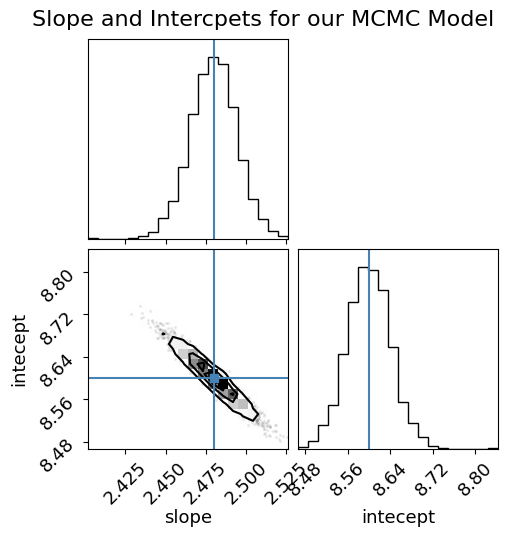

In [396]:
# Regenerate flat_samples for the line model
flat_samples_line = sampler.get_chain(discard=100, thin=15, flat=True)

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intecept"], truths=mcmc[:,1]);

# Add a title to the corner plot
fig.suptitle("Marginalized Parameters of MCMC Model", fontsize=16)

#Figure 2:

This plot shows three different ways of interperating the results from the MCMC posterior calculation, which still uses our GRB data. The top left subfigure is a histogram of our slopes from the MCMC model, with a viertical line indicating the mean of all slopes ($≈$2.475). The bottom right subfigure is a histogram of intercepts which is calculated in the same way as we did for the slopes (and will be expanded on in Figure 3), with a blue vertical line showing the mean of the intercepts ($≈$8.60). Our final subplot is in the bottom left corner, plotting slope vs intercept, with the corrisponding lines for both the intercept and slope also plotted. The wow mainly comes into play here, as the defined ring structures visible in this plot indicate a coorelation between both MCMC models, and thus a physical relationship between the slope and intercept.



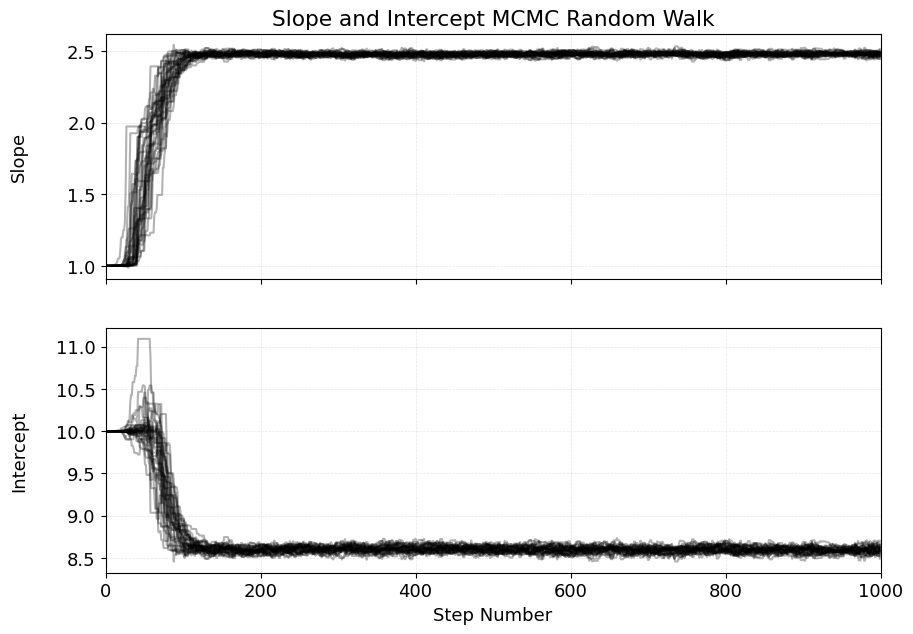

In [397]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step Number");
axes[0].set_ylabel("Slope")
axes[-1].set_ylabel("Intercept")
axes[0].set_title("Slope and Intercept MCMC Random Walk")
axes[0].grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)
axes[-1].grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)


# Figure 3:
In this figure, we use the MCMC and our GRB data to plot both the chain/random walk for the slope and the intercept. We're able to plot both against the same step number. The wow fator here is that we are able to see both the burn-in portion of the random walk, and the convergence of the random walk. This figure plots the endpoint of the random walk for every  walker that the data in Figure 2 describes, as we are able to see the same convergence of $≈$2.475 for the slope, and $≈8.60$ for intercept.


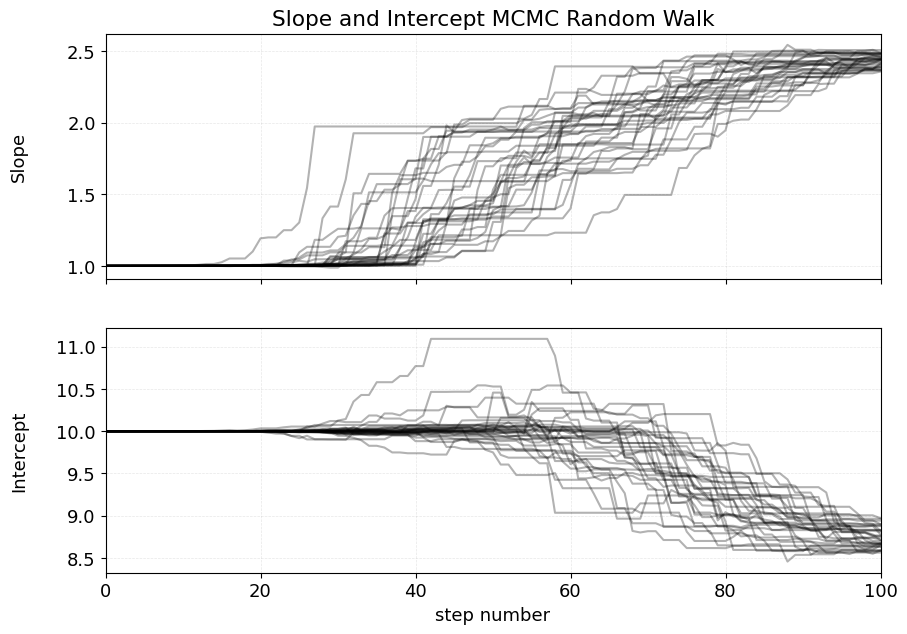

In [398]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step Number");
axes[0].set_ylabel("Slope")
axes[-1].set_ylabel("Intercept")
axes[0].set_title("Slope and Intercept MCMC Random Walk")
axes[0].grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)
axes[-1].grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)
axes[-1].set_xlabel("step number");

# Figure 4:
This figure is the zoomed-in burn-in part of Figure 3. Here, describe the burn-in process of the MCMC chains for our GRB data, where we plot both slope and intercept. The wow factor of this plot comes in the form of the 32 chains going from our inital guess to a converged state in approximately the same step number for both slope and intercept. It appears that the burn-in process for the intercept walked a much-wider range of values between $\approx$ 8 and 13, as opposed to the slope, which only walked between the $≈$ 0 and just a bit over 2.5.

In [399]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46568183, 2.48014622, 2.49410552],
       [8.55966545, 8.59977928, 8.64055554]])

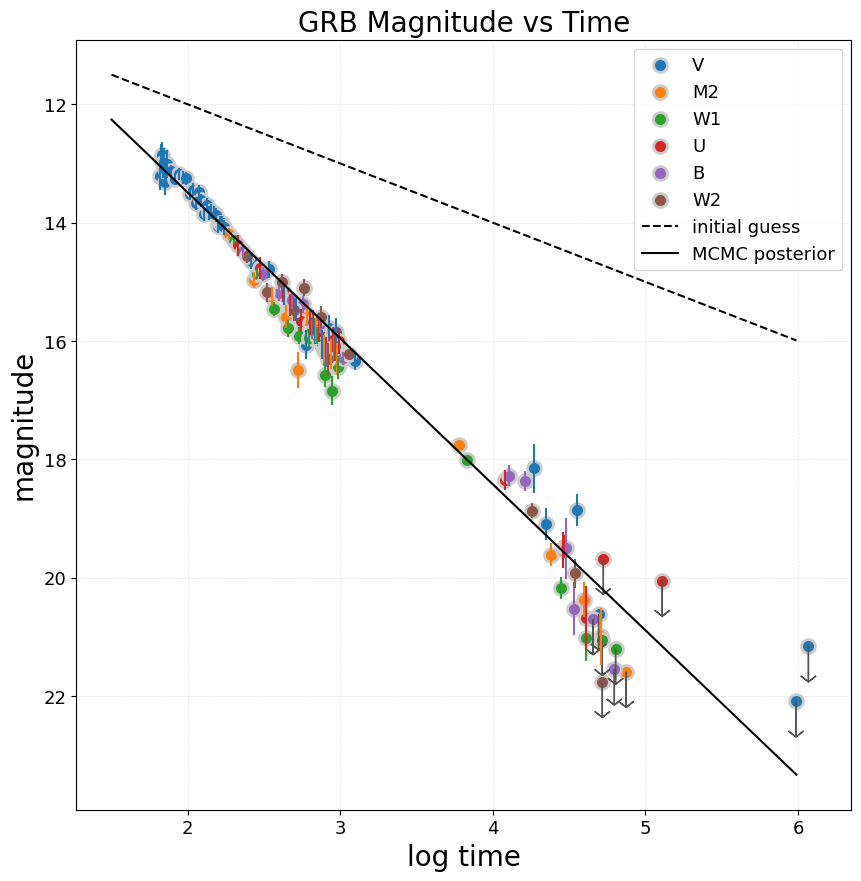

In [400]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);
pl.title("GRB Magnitude vs Time", fontsize = 20)
pl.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)

# Figure 5:
This figure is simmilar Figure 1 in Homework 5 The caption of that figure is included below for reference. This figure contains our GRB data with GRB magnitude ploted against log time with associated stellar bands, error bars, and arrors that indicate upper limits. However here, we plot our inital guess (black dashed line) and our MCMC posterior (black line). We see that while our inital guess is quite off, the MCMC posterior fits the data quite well and is quite similar to our Chi squared model in terms of slope and intercept.



> Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.


# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [401]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [402]:
grbAGnouplim.time.values.shape

(108,)

In [403]:
grbAGnouplim[grbAG.upperlimit == 0].shape

/tmp/ipython-input-3813504361.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  grbAGnouplim[grbAG.upperlimit == 0].shape


(108, 6)

In [404]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [405]:
def bpl (theta, x):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable (time)
    Return:
      model predictions for each x (array like)
    """
    tb, a1, a2, b = theta
    # Use the provided formula for magnitude
    return b - np.log10(((t/tb)**(-a1) + (t/tb)**(-a2)))

In [406]:
def log_likelihood_bpl(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  #Mag model from above
  return -0.5 * np.sum(((y - bpl(theta, x))**2) / yerr**2)

def log_prior_bpl(theta):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  tb, a1, a2, b = theta
  if 50 < tb < 60000 and a1 > 0 and a2 > 0 and 10 < b < 25:
    return 0.0
  return -np.inf

def log_posterior_bpl(theta, x, y, yerr):
  #this is the same as before! exactly! cause this is just log_likelihood + log_prior
  lp_bpl = log_prior_bpl(theta)
  if not np.isfinite(lp_bpl):
    return -np.inf
  return lp_bpl + log_likelihood_bpl(theta, t, y, yerr)

In [407]:
'''
def bpl (theta, t):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector [Tb, a1, a2, b]
      t: (array like) independent variable (linear time)
    Return:
      model predictions for each t in magnitude space (array like)
    """
    # tb and t are linear times
     #a1, a2, Tb, b = theta
    tb, a1, a2, b = theta
    # Use the provided formula for magnitude
    return b - np.log10(((t/tb)**(-a1) + (t/tb)**(-a2)))

def log_likelihood_bpl(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  #theta is [Tb, a1, a2, b]
  #t is linear time
  #y is magnitude data
  #yerr is magnitude error
  #print(f"Testing parameters: Tb={theta[0]}, a1={theta[1]}, a2={theta[2]}, b={theta[3]}") # Add this print statement
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -0.5 * np.sum(((y - bpl(theta, x))**2) / yerr**2)


def log_prior_bpl(theta):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  tb, a1, a2, b = theta
  # Priors: Tb is within data range, slopes are positive, b is reasonable magnitude offset
  if 50 < tb < 60000 and a1 > 0 and a2 > 0 and 10 < b < 25:
      return 0.0
  return -np.inf


def log_posterior_bpl(theta, x, y, yerr):
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  lp_bpl = log_prior_bpl(theta)
  if not np.isfinite(lp_bpl):
    return -np.inf
  return lp_bpl + log_likelihood_bpl(theta, x, y, yerr)

  '''

'\ndef bpl (theta, t):\n    """broken power law model\n    Input:\n      theta: (array like) 4 parameters vector [Tb, a1, a2, b]\n      t: (array like) independent variable (linear time)\n    Return:\n      model predictions for each t in magnitude space (array like)\n    """\n    # tb and t are linear times\n     #a1, a2, Tb, b = theta\n    tb, a1, a2, b = theta\n    # Use the provided formula for magnitude\n    return b - np.log10(((t/tb)**(-a1) + (t/tb)**(-a2)))\n\ndef log_likelihood_bpl(theta, x, y, yerr):\n  # use the same log_likelihood as before (chi2) but with the new model\n  #theta is [Tb, a1, a2, b]\n  #t is linear time\n  #y is magnitude data\n  #yerr is magnitude error\n  #print(f"Testing parameters: Tb={theta[0]}, a1={theta[1]}, a2={theta[2]}, b={theta[3]}") # Add this print statement\n  #chi2 likelihood : (data-model)**2 / uncertainty **2\n  return -0.5 * np.sum(((y - bpl(theta, x))**2) / yerr**2)\n\n\ndef log_prior_bpl(theta):\n  # similar to before, but choose relevant

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [408]:
ig = [1000, 0.005, 0.0025, 12] # Changed from order [a1, a2, Tb, b] to [Tb, a1, a2, b]. Changed guess from the original [1000, 0.2, 5, 20].
#what does the minimize function need to take as arguments?
# Add bounds to the minimization
#bounds = [(50, 60000), (0, 0.1), (0, 0.1), (10, 25)]

nll = lambda *args: -log_likelihood_bpl(*args)

# FBB define something like nll = lambda *args: -log_likelihood_bpl(*args) and do minimize of nll instead - no bounds needed
soln = minimize(nll, ig, args=(x, y, s),)
print(soln)
print("")
print("best fit parameters from the minimization of chi2: " +
       "time of break {:.2f},  early slope {:.2f}, late slope {:.2f}, intercept {:.2f}".format(*soln.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 108.7326572775876
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 76
      jac: [ 1.526e-05  9.537e-07  1.526e-05  1.049e-05]
 hess_inv: [[ 2.444e-04 -1.850e-04  1.290e-03  3.299e-04]
            [-1.850e-04  3.416e-03 -1.081e-02 -3.488e-03]
            [ 1.290e-03 -1.081e-02  3.655e-02  1.166e-02]
            [ 3.299e-04 -3.488e-03  1.166e-02  3.913e-03]]
     nfev: 1054
     njev: 208

best fit parameters from the minimization of chi2: time of break 273.58,  early slope 2.15, late slope 3.55, intercept 15.05


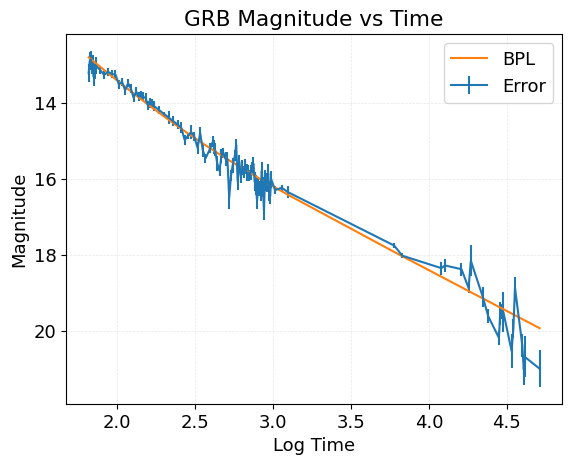

In [409]:
ax = pl.gca()
ig = soln.x # the initial guess for the MCMC
ax.yaxis.set_inverted(True)
# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s, label = "Error")
pl.plot(x, bpl(ig, t), label = "BPL")
#pl.plot(x, bpl(ig, x_nolog))
pl.xscale("linear")
pl.legend()
pl.title("GRB Magnitude vs Time")
pl.xlabel("Log Time")
pl.ylabel("Magnitude")
pl.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)

#Figure 6:
In this figure, we running our GRB data through our broken power law (BPL) in order to plot the BPL function. We plot Magnatude against time, the same way that we had for Figure 1 and Figure 5, which also includes the same range of magnatude and log time since we are still using the GRB dataset. The lines plotted are our BPL function and the error on the GRB data. The wow factor here is that we are able to see a slight curve to the BPL function, and that our error is strikingly linear and aligns with our BPL for log time 3.0-4.0. Also the errorsand BPL are roughly in line for time 2.0-3.0.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [439]:
# set the emcee hyperparameters
ig = [1000, 0.005, 0.0025, 12]
# Using Chi Squared minimization as Hyperparameters:
#ig = [273, 2.15, 3.55, 15.05]
#initialize N walkers
nwalkers = 32
ndim = len(ig)
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = 0
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(x, y, s))

In [440]:
pos.shape

(32, 4)

In [441]:
# run the model
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:09<00:00, 553.62it/s]


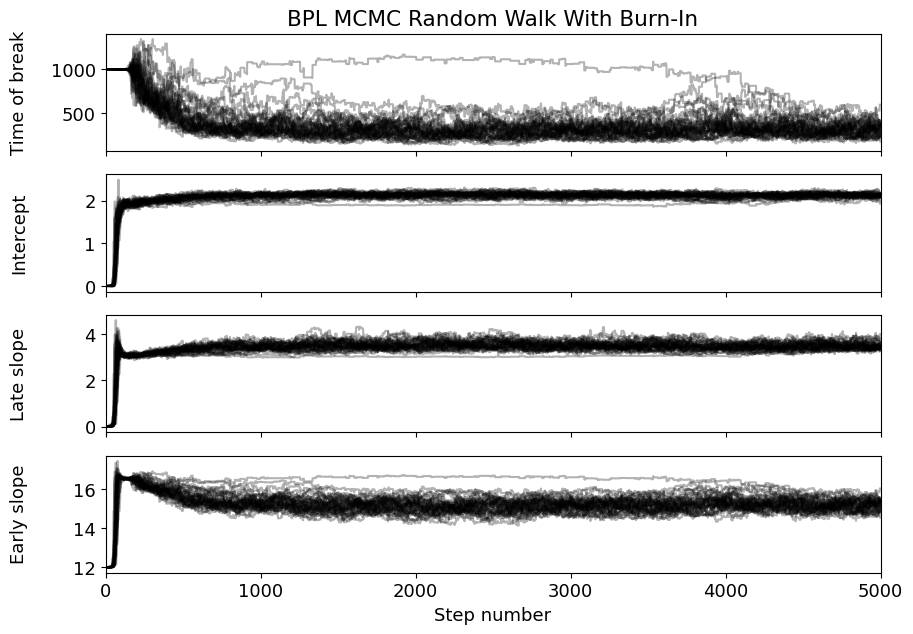

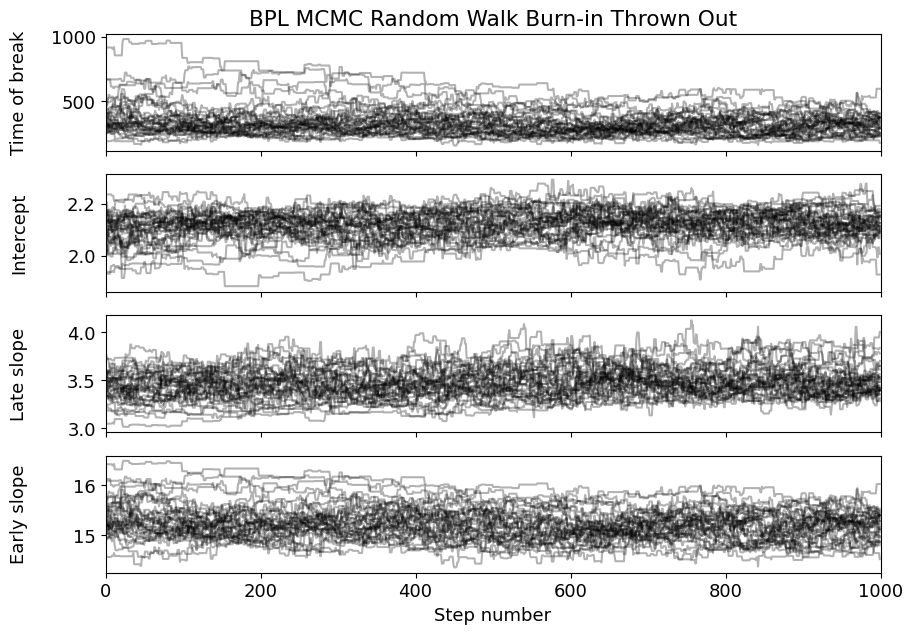

In [442]:
#plot of chains without burn-in process
samples = 0
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");
axes[0].set_ylabel("Time of break")
axes[-1].set_ylabel("Early slope")
axes[-2].set_ylabel("Late slope")
axes[-3].set_ylabel("Intercept")
axes[0].set_title("BPL MCMC Random Walk With Burn-In")
plt.show()

#plot the chains
discard_var = 4000
samples = 0
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=discard_var)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number");
axes[0].set_ylabel("Time of break")
axes[-1].set_ylabel("Early slope")
axes[-2].set_ylabel("Late slope")
axes[-3].set_ylabel("Intercept")
axes[0].set_title("BPL MCMC Random Walk Burn-in Thrown Out")
plt.show()




#Figure 7:
In this figure, we are able to plot our MCMC walks for our borken power law. We use all 32 walkers for each one of our inital guess variables--the time of break, intercept, late slope, and early slope against step number.

This figure is made of two plots, one including our burn-in process and one excluding it, throwing out the first 4000 steps out of a computation of 5000 steps. This data with the burn-in thrown-out version of our data will be used for all following computation.

We set our inital guesses (hyperparameters) to the sames ones used for Homework 3 part 2, `ig = [1000, 0.005, 0.0025, 12]`. Our wow factor here includes how the MCMC chains adjust from their inital guesses and swing wildly in value before every chain converges on a similar value, seen in the "Burn In Thrown Out" plot.

In [443]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=discard_var, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])
mcmc[:,1]
theta = mcmc[:,1]

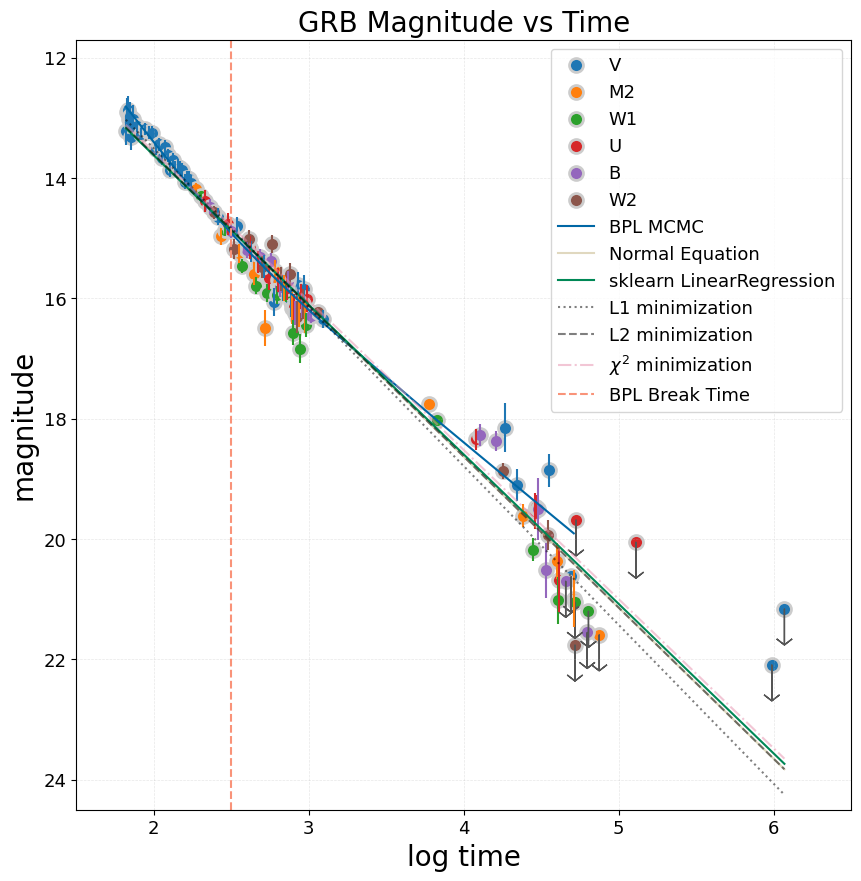

In [444]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]


#ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
#                           grbAG.logtime.values), ls="--", c="k", label="MCMC")


# Add the broken power law model from MCMC
# Use all time values for plotting the BPL model
ax.plot(grbAGnouplim.logtime.values, bpl(mcmc[:,1], grbAGnouplim.time.values),
        ls="-", c='#'+colors[4], label="BPL MCMC")


#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime.values,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime.values,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime.values,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[0,1]), color='#'+colors[5], linestyle='--', label='BPL Break Time') # Plot the break time


#Attempt to construct Broken Power Law that extends over the entire plot
#x_bpl = np.linspace(grbAG.time.min(), grbAG.time.max(), 108)
#y_bpl = bpl(theta, x_bpl)
#pl.plot(x_bpl, y_bpl, color = "purple", linestyle = '--', label='Extended BPL')


pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.legend()
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);
pl.title("GRB Magnitude vs Time", fontsize = 20)
pl.grid(True, linestyle = "--", linewidth = 0.5, alpha = 0.3)

# Figure 8:
Like Figure 1 and Figure 5, we are plotting our GRB data with GRB magnitude ploted against log time with associated stellar bands, error bars, and arrows that indicate upper limits. here, we plot all of our previous fit models including our Normal equation, sklearn LinearRegression, L1 minimization, L2 minimization, and $χ^2$ models. The wow factor comes into play as we also plot our Broken Power Law model, seen in blue, and are able to compare it to all of our previous models. We are able to see that our BPL curves slightly at a certain point, that point illustrated by the horizontal "BPL Break Time" dashed line. As a broken power law, it is inharently not linear unlike the rest of our models, and is better to take into account midsection of our data, that appears to not follow the majority of our linear fits.

Because we used data that did not encompass the upper limit of the data, the BPL fit does not account for the upper limit of the data, hence it stops unlike the rest of the fit models.

## plot the marginalized posterior distributions of the parameters

Text(0.5, 0.98, 'Marginalized Posterior Distribution of MCMC Parameters')

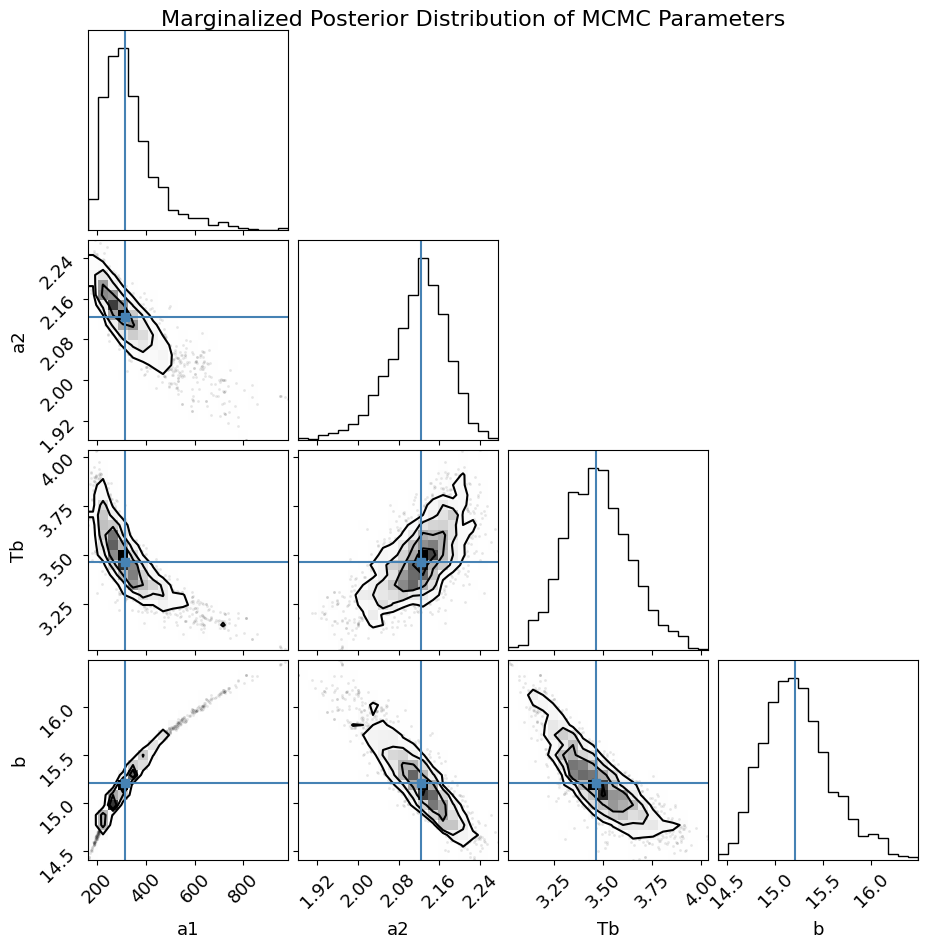

In [447]:
# Adding four parameters instead of two parameters from corner plot
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);

fig.suptitle("Marginalized Posterior Distribution of MCMC Parameters", fontsize=16)

# Figure 9:
This plot consists of 10 different subplots, which all coorispond to different parameters present in our broken power law, stemming from our theta. Our four parameters are Tb (The time which the BPL breaks), a1 (the first slope in our BPL), a2 (the second slope in our BPL), and b (the nuisance parameter). There are blue horizontal and vertical lines in every plot, coorisponding to the mean of each respective axis.

There are histograms for every parameter, representing the uncertainty of each parameter. All of the histograms with fairly clean tails--all but a1, which is lopsided for larger values.  

The eliptical contours represent covarience between parameters. The farther each plot is from a circle, the stronger the covarience between the parameters. Addtionally, the direction of the diagonal represents either a positive or negative corellation between parameters. The analysis of each subplot is as follows (note, when discussing covarience, mild and strong describe how unlike a circle the eliptical contour plots are):


*   a2 vs a1 | A mild negative covarience.
*   Tb vs a1 | A mild negative covarience.
*   b vs a1 | A very strong positive covarience.
*   Tb vs a2 | A mild positive covarience.
*   b cs tb | A mild negative covarience.

The wow factor of these plots are that it seems like all of the parameters are covarient to some degree, all creating mild-to-strong diagonal contour plots.







EXTRA CREDIT FOR 461 REQUIRED FOR 661

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [417]:
print("..."... log_likelihood(mcmc_line[:,1], x, y, s)) #control the decimal digits!

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-1832605796.py, line 1)

In [ ]:
print("..."... log_likelihood_bpl(mcmc[:,1], x_nolog, y, s))

## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [ ]:
def like_ratio_statistics(...):
  return ...

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions



In [ ]:
.... #your work here

# your conclusions here

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [ ]:
def aic(...):
  return


def bic(...):
  return


In [ ]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {0:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], x_nolog, y, s), 4)))

# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model